In [1]:
from pathlib import Path
import os

os.environ['LANDSLIDE_DENSITY_THRESHOLD'] = (
    '0.0000001'  # the percentage landslide required for an image to be classified as landslided (check landnet.config module)
)

from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    RandomCAM,
    LayerCAM,
    GradCAMElementWise,
    EigenGradCAM,
)
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.metrics.road import ROADCombined
from torch import nn
import numpy as np
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import clear_output

from landnet.config import MODELS_DIR, FIGURES_DIR
from landnet.enums import Mode, GeomorphometricalVariable, Architecture
from landnet.modelling import torch_clear
from landnet.modelling.classification.lightning import LandslideImageClassifier
from landnet.modelling.classification.models import get_architecture
from landnet.modelling.classification.dataset import (
    ConcatLandslideImageClassification,
    LandslideImageClassification,
)
from landnet.features.grids import get_grid_for_variable
from landnet.features.tiles import TileConfig, TileSize
from landnet.modelling.dataset import get_default_transform
from landnet.typing import TuneSpace

clear_output()

In [2]:
checkpoint = (
    MODELS_DIR
    / 'convnext_100x100_10vars/convnext_100x100_10vars/TorchTrainer_cf20a57d_5_batch_size=4,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-28_00-30-26/checkpoint_000016/checkpoint.ckpt'
)
assert checkpoint.exists()

tile_config = TileConfig(TileSize(100, 100), overlap=0)
model_config: TuneSpace = {
    'batch_size': 1,
    'learning_rate': 0.000001,
    'tile_config': tile_config,
}

variables = [
    GeomorphometricalVariable.HILLSHADE,
    GeomorphometricalVariable.TOPOGRAPHIC_POSITION_INDEX,
    GeomorphometricalVariable.NEGATIVE_TOPOGRAPHIC_OPENNESS,
    GeomorphometricalVariable.DIGITAL_ELEVATION_MODEL,
    GeomorphometricalVariable.EASTNESS,
    GeomorphometricalVariable.SLOPE,
    GeomorphometricalVariable.REAL_SURFACE_AREA,
    GeomorphometricalVariable.FLOW_LINE_CURVATURE,
    GeomorphometricalVariable.TERRAIN_RUGGEDNESS_INDEX,
    GeomorphometricalVariable.LOCAL_CURVATURE,
]

In [3]:
grids = {}
datasets = {}

for mode in (Mode.TRAIN, Mode.TEST, Mode.VALIDATION):
    grids[mode] = [
        get_grid_for_variable(
            variable,
            tile_config=tile_config,
            mode=mode,
        )
        for variable in variables
    ]
    dataset = ConcatLandslideImageClassification(
        landslide_images=[
            LandslideImageClassification(
                grid,
                mode,
                transform=get_default_transform(),
            )
            for grid in grids[mode]
        ],
        augment_transform=None,
    )
    dataloader = DataLoader(
        dataset,
        batch_size=1,
        num_workers=4,
        shuffle=False,
        prefetch_factor=4,
        persistent_workers=True,
        pin_memory=True,
    )
    datasets[mode] = list(dataloader)

clear_output()

/tmp/ipykernel_24290/4017671577.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


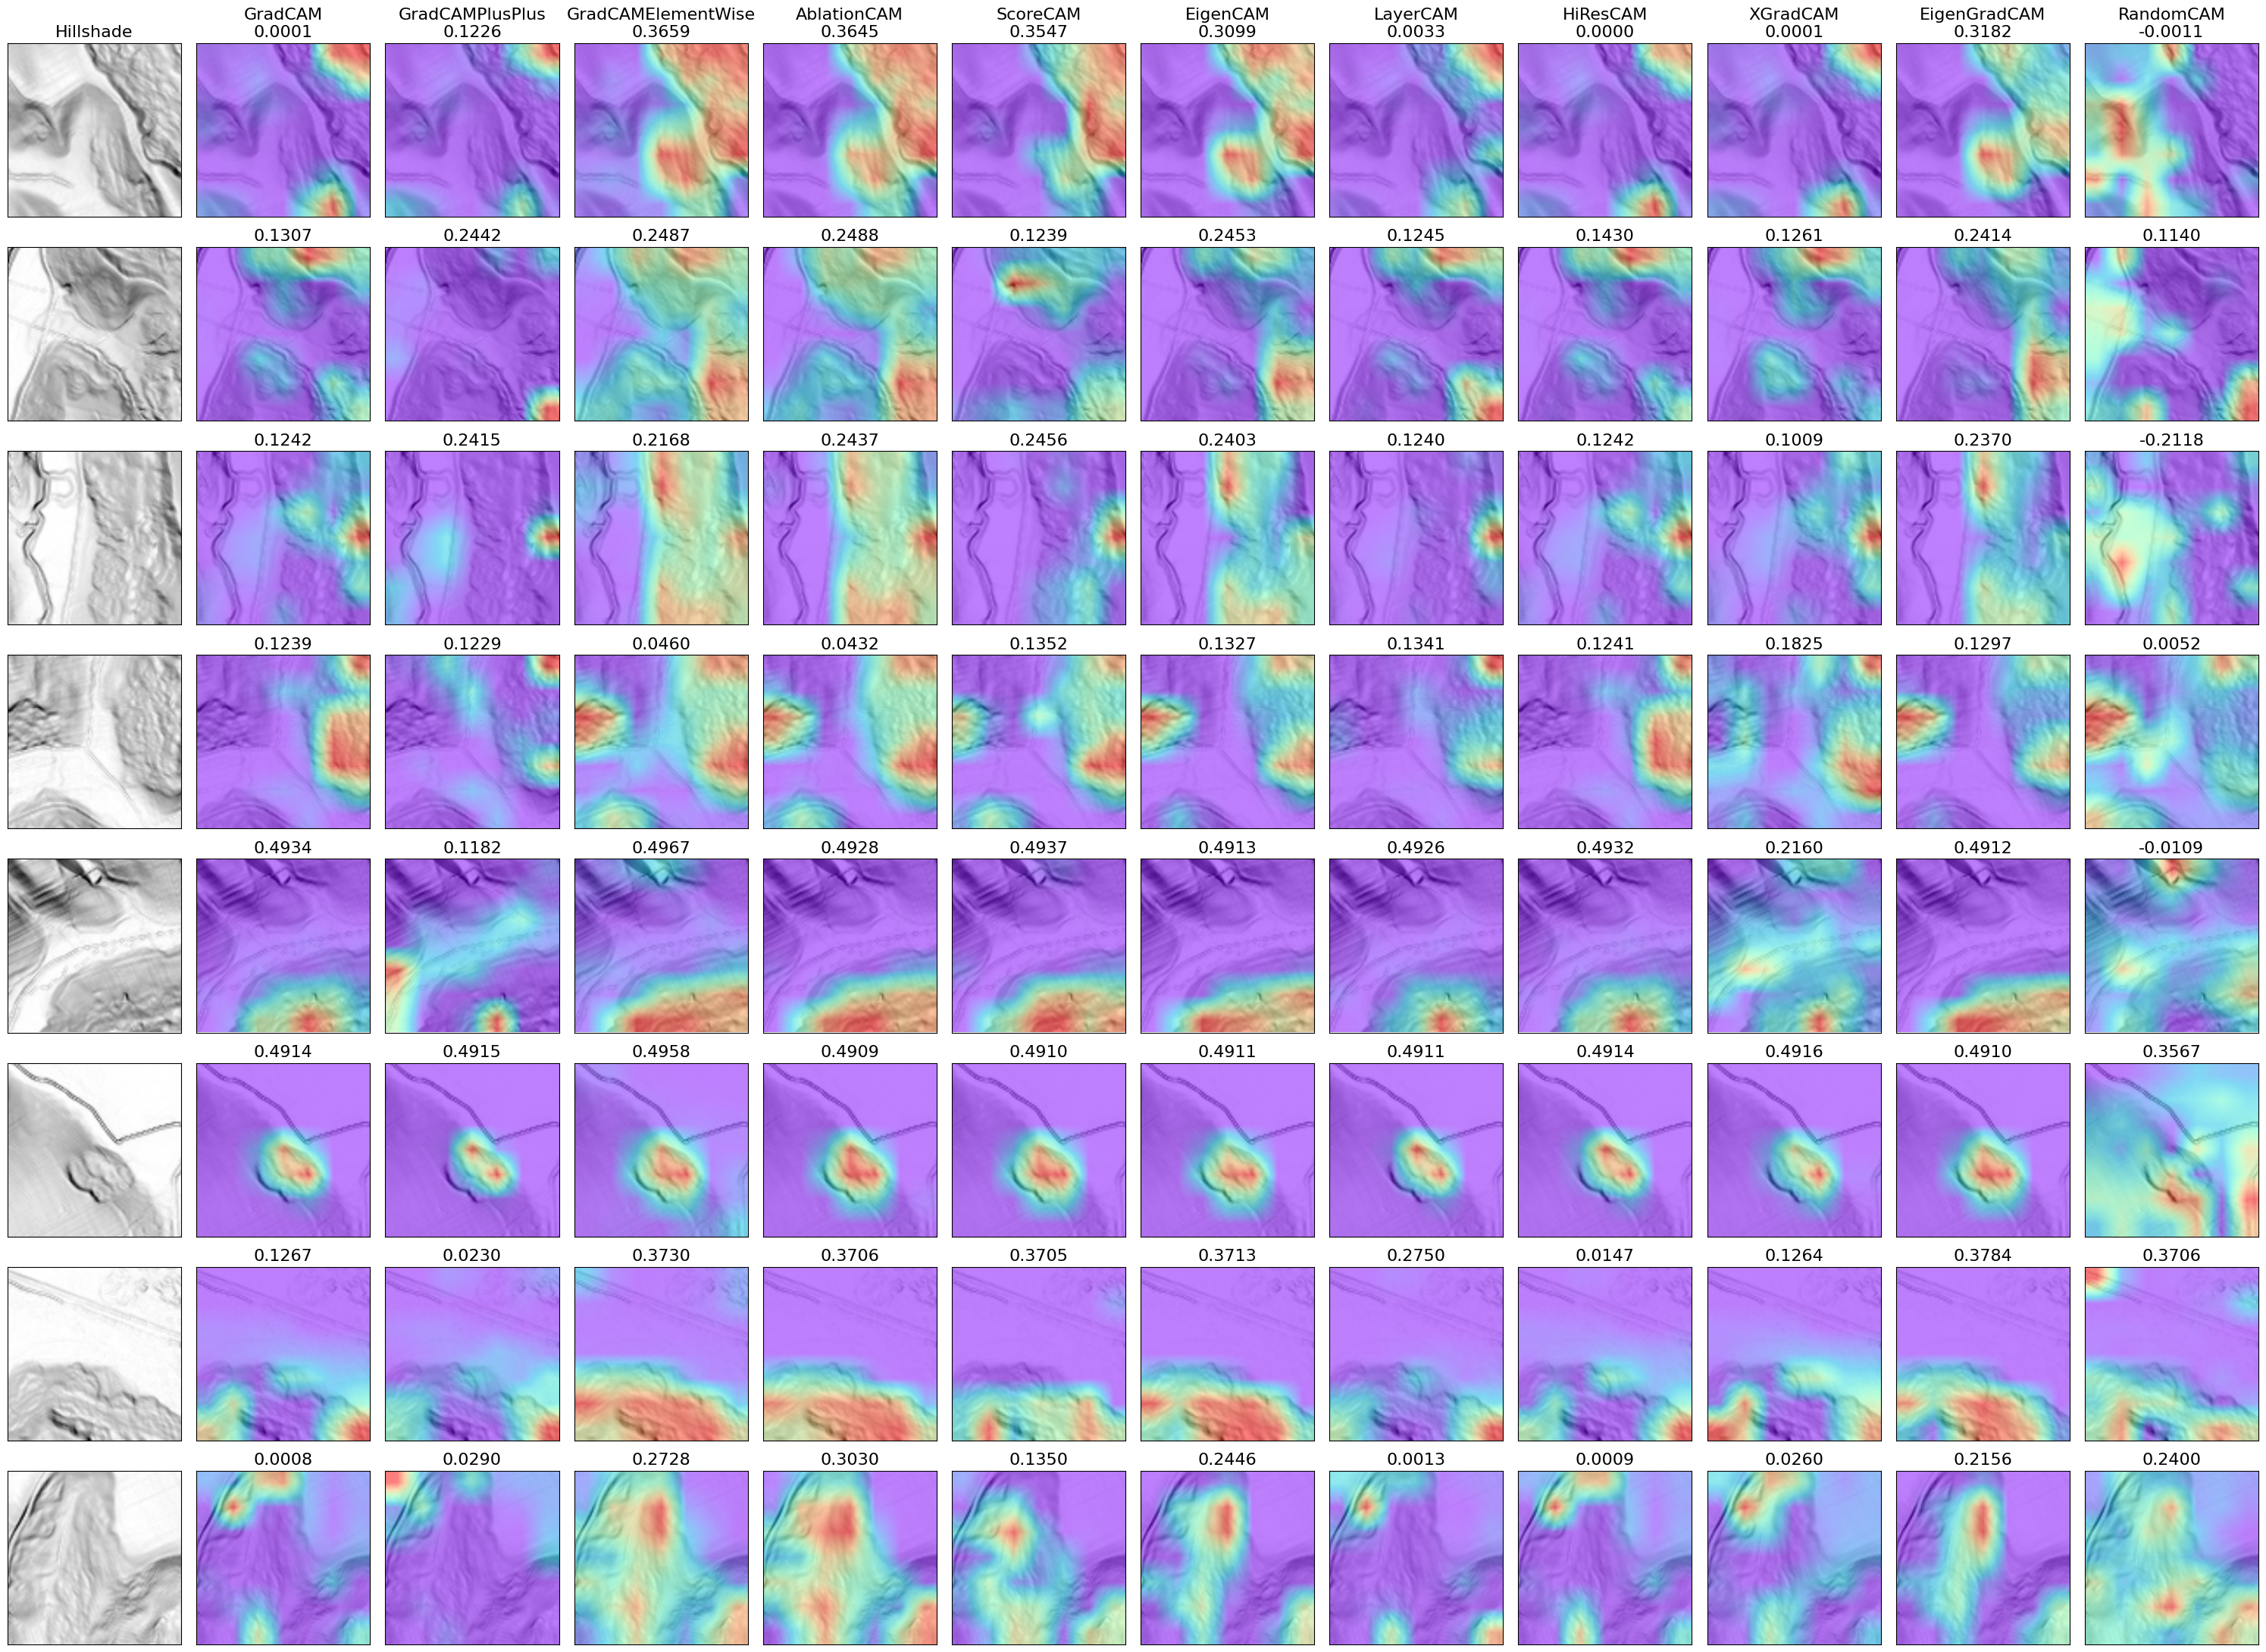

In [4]:
# Compares different GradCAM methods

torch_clear()

classifier = LandslideImageClassifier.load_from_checkpoint(
    checkpoint,
    model=get_architecture(Architecture('convnext'))(
        len(variables), Mode.INFERENCE
    ),
)

methods = [
    GradCAM,
    GradCAMPlusPlus,
    GradCAMElementWise,
    AblationCAM,
    ScoreCAM,
    EigenCAM,
    LayerCAM,
    HiResCAM,
    XGradCAM,
    EigenGradCAM,
    RandomCAM,
]
# The index of the tiles to select from the test area
sample_indices = [297, 265, 392, 360, 241, 164, 90, 357]
n_samples = len(sample_indices)
n_methods = len(methods)
target_layers = classifier.model[-1].features[-1]

fig = plt.figure(figsize=(30.0, 30.0))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(n_samples, n_methods + 1),
    axes_pad=(0.2, 0.4),
    share_all=True,
)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

fontdict = {'fontsize': 16}
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])

for i, sample_index in enumerate(sample_indices):
    hillshade = datasets[Mode.TEST][sample_index][0][0, 0].numpy()
    hillshade_index = i * (n_methods + 1)
    grid[hillshade_index].imshow(hillshade, cmap='binary')

    if i == 0:
        grid[hillshade_index].set_title('Hillshade', fontdict=fontdict)

    results = {}
    for j, method in enumerate(methods, start=1):
        with method(model=classifier, target_layers=target_layers) as cam:
            input_tensor = datasets[Mode.TEST][sample_index][0].to(
                classifier.device
            )
            targets = [nn.Sigmoid()]
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cams[0, :]
            cam_index = hillshade_index + j
            grid[cam_index].imshow(hillshade, cmap='binary')
            grid[cam_index].imshow(grayscale_cam, cmap='rainbow', alpha=0.5)
            scores = cam_metric(
                input_tensor, grayscale_cams, targets, classifier
            )
            score = scores[0] * 100
            title = f'{scores[0]:.4f}'
            if i == 0:
                title = '\n'.join([method.__name__, title])
            grid[cam_index].set_title(title, fontdict=fontdict)

clear_output()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'gradcams.png', dpi=300, bbox_inches='tight')

In [ ]:
# Saves heatmaps as geotif to produce the GradCAM map

torch_clear()

classifier = LandslideImageClassifier.load_from_checkpoint(
    checkpoint,
    model=get_architecture(Architecture('convnext'))(
        len(variables), Mode.INFERENCE
    ),
)

method = GradCAMElementWise

target_layers = classifier.model[-1].features[-1]

for mode, tensors in datasets.items():
    print(f'Saving tiles for {mode!r}')
    for i, input_tensor in enumerate(tensors):
        targets = [
            BinaryClassifierOutputTarget(1) for target in input_tensor[1]
        ]
        visualizations = []
        with method(model=classifier, target_layers=target_layers) as cam:
            grayscale_cams = cam(input_tensor=input_tensor[0], targets=targets)

            for img_index in range(input_tensor[0].shape[0]):
                grayscale_cam = grayscale_cams[img_index, :]
                visualizations.append(grayscale_cam)

        for j, vis in enumerate(visualizations):
            index = i * model_config['batch_size'] + j
            vis_resized = np.expand_dims(cv2.resize(vis, (100, 100)), 0)
            out_file = Path(
                f'./{method.__name__}/{mode.value}/{input_tensor[1][j]}_{index}.png'
            )
            os.makedirs(out_file.parent, exist_ok=True)
            grids[mode][0].write_tile(
                index,
                vis_resized,
                out_dir=out_file.parent,
                prefix=out_file.with_suffix('.tif').name,
            )

DEBUG: Adapting model input channels from 10 to 3
Saving tiles for <Mode.TRAIN: 'train'>
